## Stock Price Prediction using Stacked LSTM

In [1]:
# !pip install pandas_datareader

In [2]:
# !pip install tiingo

In [3]:
import pandas_datareader as pdr

In [4]:
from tiingo import TiingoClient

# Configure API key
config = {'api_key': 'b8f79618f5db6d6643956d4fde1a66b96a36ec55'}
client = TiingoClient(config)

In [5]:
# Collect data
df = client.get_dataframe(tickers='AAPL',startDate='2000-01-01', endDate='2024-11-15')
df.head()

,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
date,,,,,,,,,,,,
2000-01-03 00:00:00+00:00,111.94,112.50,101.69,104.87,4783900,0.843017,0.847234,0.765824,0.789773,535797335,0.0,1.0
2000-01-04 00:00:00+00:00,102.50,110.62,101.19,108.25,4574800,0.771925,0.833076,0.762059,0.815228,512378112,0.0,1.0
2000-01-05 00:00:00+00:00,104.00,110.56,103.00,103.75,6949300,0.783221,0.832624,0.775690,0.781338,778322378,0.0,1.0
2000-01-06 00:00:00+00:00,95.00,107.00,95.00,106.12,6856900,0.715442,0.805814,0.715442,0.799187,767973567,0.0,1.0
2000-01-07 00:00:00+00:00,99.50,101.00,95.50,96.50,4113700,0.749332,0.760628,0.719208,0.726739,460734860,0.0,1.0


In [6]:
df.shape

(6259, 12)

In [7]:
df.to_csv('AAPL.csv',index=False)

In [8]:
import pandas as pd

In [9]:
df = pd.read_csv('AAPL.csv')

In [10]:
df.head()

,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,111.94,112.50,101.69,104.87,4783900,0.843017,0.847234,0.765824,0.789773,535797335,0.0,1.0
1,102.50,110.62,101.19,108.25,4574800,0.771925,0.833076,0.762059,0.815228,512378112,0.0,1.0
2,104.00,110.56,103.00,103.75,6949300,0.783221,0.832624,0.775690,0.781338,778322378,0.0,1.0
3,95.00,107.00,95.00,106.12,6856900,0.715442,0.805814,0.715442,0.799187,767973567,0.0,1.0
4,99.50,101.00,95.50,96.50,4113700,0.749332,0.760628,0.719208,0.726739,460734860,0.0,1.0


In [11]:
df1 = df['close']

In [12]:
df1.shape

(6259,)

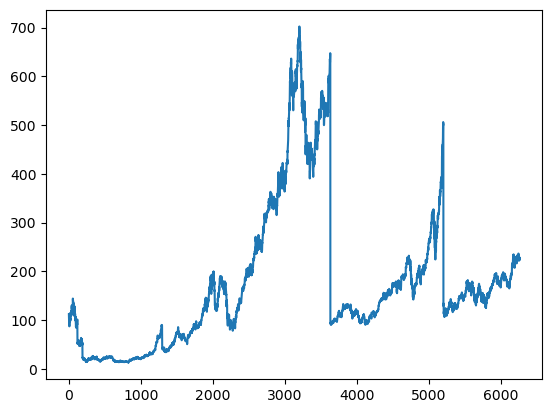

In [13]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [14]:
## LSTM are sensitive to scale of data so i am applying min_max scaler

In [15]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [16]:
scaler1 = MinMaxScaler(feature_range=(0,1))
df1 = scaler1.fit_transform(np.array(df1).reshape(-1,1))

In [17]:
df1.shape

(6259, 1)

### splitting date into train test

In [18]:
training_size = int(len(df1)*0.70)
test_size = len(df1) - training_size

In [19]:
train_data,test_data = df1[0:training_size,:],df1[training_size:len(df1),:]

In [20]:
def create_dataset(dataset,timestep=1):
    datax,datay = [],[]
    for i in range(len(dataset)-timestep-1):
        a = dataset[i:i+timestep,0]
        datax.append(a)
        datay.append(dataset[i+timestep,0])
        
    return np.array(datax),np.array(datay)

In [21]:
#  reshape into x = t,t+1,t+2 ,y=t+4
timestep = 120
x_train,y_train = create_dataset(train_data,timestep)
x_test,y_test = create_dataset(test_data,timestep)


In [22]:
x_train

array([[0.14342942, 0.129728  , 0.13190514, ..., 0.12791373, 0.0616999 ,
        0.05897123],
       [0.129728  , 0.13190514, 0.11884235, ..., 0.0616999 , 0.05897123,
        0.05598131],
       [0.13190514, 0.11884235, 0.12537374, ..., 0.05897123, 0.05598131,
        0.05952277],
       ...,
       [0.14046852, 0.1393219 , 0.14054109, ..., 0.2041859 , 0.20351824,
        0.2042875 ],
       [0.1393219 , 0.14054109, 0.14210862, ..., 0.20351824, 0.2042875 ,
        0.20391013],
       [0.14054109, 0.14210862, 0.14369067, ..., 0.2042875 , 0.20391013,
        0.20399721]])

In [23]:
x_train.shape,y_train.shape

((4260, 120), (4260,))

In [24]:
x_test.shape,y_test.shape

((1757, 120), (1757,))

In [25]:
# reshape input into [samples,timesteps,features] which is required for stacked LSTM
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1)

## CREATE LSTM MODEL

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM

In [31]:
model = Sequential()
model.add(LSTM(200,return_sequences=True,input_shape=(120,1)))
model.add(LSTM(100,return_sequences=True))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(25))
model.add(Dense(1))

In [32]:
model.compile(loss='mean_squared_error',optimizer='adam')

In [33]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 120, 200)          161600    
                                                                 
 lstm_5 (LSTM)               (None, 120, 100)          120400    
                                                                 
 lstm_6 (LSTM)               (None, 120, 50)           30200     
                                                                 
 lstm_7 (LSTM)               (None, 25)                7600      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 319826 (1.22 MB)
Trainable params: 319826 (1.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [34]:
model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=50,batch_size=64,verbose=True)

Epoch 1/50
67/67 [==============================] - 36s 391ms/step - loss: 0.0074 - val_loss: 0.0022
Epoch 2/50
67/67 [==============================] - 24s 361ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 3/50
67/67 [==============================] - 24s 366ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 4/50
67/67 [==============================] - 25s 367ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 5/50
67/67 [==============================] - 24s 365ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 6/50
67/67 [==============================] - 24s 364ms/step - loss: 0.0011 - val_loss: 9.4457e-04
Epoch 7/50
67/67 [==============================] - 26s 384ms/step - loss: 9.9651e-04 - val_loss: 8.4748e-04
Epoch 8/50
67/67 [==============================] - 25s 370ms/step - loss: 9.0961e-04 - val_loss: 9.2819e-04
Epoch 9/50
67/67 [==============================] - 25s 370ms/step - loss: 7.6287e-04 - val_loss: 6.7713e-04
Epoch 10/50
67/67 [==============================] - 25s 368ms/

## predictions

In [35]:
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

55/55 [==============================] - 4s 74ms/step


In [36]:
#  transfer back to original form
train_predict = scaler1.inverse_transform(train_predict)
test_predict = scaler1.inverse_transform(test_predict)

In [37]:
train_predict[0]

array([78.474144], dtype=float32)

In [38]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

243.5564220489192

In [39]:
math.sqrt(mean_squared_error(y_test,test_predict))

197.67514607448544

## Plot the predictions and original prices

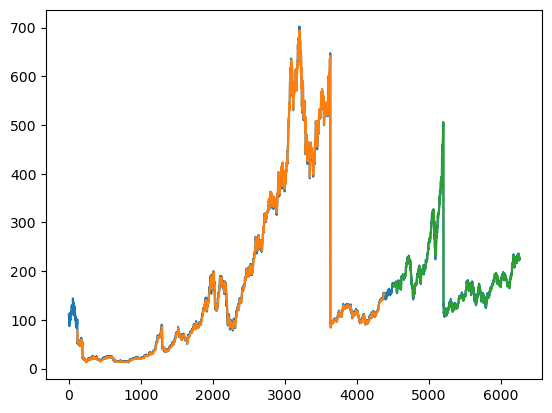

In [41]:
look_back = 120
# shift train prediction for plotting
train_predict_plot = np.empty_like(df1)
train_predict_plot[:,:]=np.nan
train_predict_plot[look_back:len(train_predict)+look_back,:] = train_predict

# shift test prediction for plotting
test_predict_plot = np.empty_like(df1)
test_predict_plot[:,:] = np.nan
test_predict_plot[len(train_predict)+2*look_back+1:len(df1)-1,:] = test_predict

# plot baseline and predictions
plt.plot(scaler1.inverse_transform(df1))
plt.plot(train_predict_plot)
plt.plot(test_predict_plot)
plt.show()


# Doing predictions for next 30 days

In [42]:
len(test_data)

1878

In [52]:
input_features = test_data[-120:,:].reshape(1,-1)
input_features.shape

(1, 120)

In [53]:
input_features = list(input_features)
input_features = input_features[0].tolist()
input_features

[0.2571482481349241,
 0.25859966907602544,
 0.25999303317948275,
 0.2625765624546431,
 0.26304101715579553,
 0.2652471769862696,
 0.2632297018781387,
 0.26672762634619296,
 0.2612557693982409,
 0.2816192052018927,
 0.2902116171732126,
 0.2919097796743012,
 0.28936979302737387,
 0.2954367325611774,
 0.29198235072135625,
 0.28529130018287907,
 0.28211268832186714,
 0.283056111933583,
 0.28440593340880727,
 0.29047287294261087,
 0.29170658074254696,
 0.28665563586751436,
 0.29555284623646555,
 0.30066184794914225,
 0.30251966675375197,
 0.3094719730616274,
 0.31162007605445735,
 0.3128682980638045,
 0.3191094081105402,
 0.311257220819182,
 0.31556794101425295,
 0.32117042584690414,
 0.3217800226421667,
 0.31315858225202475,
 0.3063369038288485,
 0.30652558855119166,
 0.3060175912218062,
 0.30754158320996255,
 0.2981508897210369,
 0.29662689773288053,
 0.29730906557519815,
 0.29771546343870653,
 0.2985282591657233,
 0.3032889198525357,
 0.2978896339516387,
 0.3000667653632907,
 0.284696217

In [54]:
output = []
n_steps = 120
i = 0
while i<30:
    x_input=np.array(input_features[-120:])
    # print("{} day input {}".format(i,x_input))
    x_input=x_input.reshape(1,-1)
    x_input = x_input.reshape((1, 120, 1))
    #print(x_input)
    yhat = model.predict(x_input, verbose=True)
    print(f"for day {i+1} stock closing price predictions is : {yhat[0][0]}") 
    input_features.extend(yhat[0].tolist())
#     input_features=input_features[1:]
    output.extend(yhat.tolist())
    i+=1
    


1/1 [==============================] - 0s 47ms/step
for day 1 stock closing price predictions is : 0.3091892898082733
1/1 [==============================] - 0s 46ms/step
for day 2 stock closing price predictions is : 0.309138685464859
1/1 [==============================] - 0s 45ms/step
for day 3 stock closing price predictions is : 0.30904993414878845
1/1 [==============================] - 0s 45ms/step
for day 4 stock closing price predictions is : 0.3089771568775177
1/1 [==============================] - 0s 43ms/step
for day 5 stock closing price predictions is : 0.3088996708393097
1/1 [==============================] - 0s 48ms/step
for day 6 stock closing price predictions is : 0.30880799889564514
1/1 [==============================] - 0s 44ms/step
for day 7 stock closing price predictions is : 0.308705598115921
1/1 [==============================] - 0s 44ms/step
for day 8 stock closing price predictions is : 0.3085988759994507
1/1 [==============================] - 0s 45ms/step
for 

In [57]:
# plt.plot(day_pred,scaler.inverse_transform(output))

output = scaler1.inverse_transform(output).tolist()

In [47]:
from datetime import datetime, timedelta
date = datetime(2024, 11, 16)
i=0
while i<30:
    print(f"closing price prediction for day {date} is {output[i]}")
    date = date + timedelta(days=1)
    i+=1

closing price prediction for day 2024-11-16 00:00:00 is [226.14523689210412]
closing price prediction for day 2024-11-17 00:00:00 is [226.11037151157853]
closing price prediction for day 2024-11-18 00:00:00 is [226.04922362983226]
closing price prediction for day 2024-11-19 00:00:00 is [225.9990815454721]
closing price prediction for day 2024-11-20 00:00:00 is [225.94569521486756]
closing price prediction for day 2024-11-21 00:00:00 is [225.88253507912157]
closing price prediction for day 2024-11-22 00:00:00 is [225.81198298990725]
closing price prediction for day 2024-11-23 00:00:00 is [225.7384535861015]
closing price prediction for day 2024-11-24 00:00:00 is [225.66535537958143]
closing price prediction for day 2024-11-25 00:00:00 is [225.5949880892038]
closing price prediction for day 2024-11-26 00:00:00 is [225.5286453068256]
closing price prediction for day 2024-11-27 00:00:00 is [225.46679929614064]
closing price prediction for day 2024-11-28 00:00:00 is [225.4093679243326]
clos